In [35]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [36]:
train_data_dir = "preprocessed/train"

In [37]:
valid_data_dir =  "preprocessed/valid"

In [38]:
test_data_dir = "preprocessed/test"

In [39]:
labels = os.listdir(train_data_dir)

Number of no wildfire images : 1500
Number of wildfire images : 1500


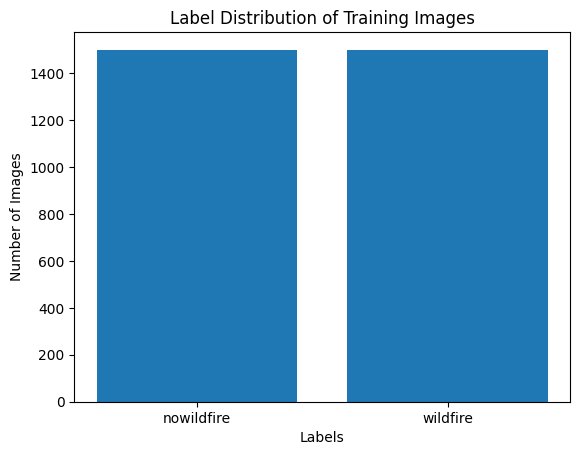

In [40]:
label_counts = Counter()
for label in labels:
    label_path = os.path.join(train_data_dir, label)
    label_counts[label] = len(os.listdir(label_path))

print("Number of no wildfire images : " + str(label_counts["nowildfire"]))
print("Number of wildfire images : " + str(label_counts["wildfire"]))

# Plot the distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Label Distribution of Training Images')
plt.show()

In [41]:
# Set image size for resizing
img_width, img_height = 224, 224
batch_size = 64
# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='binary') 
valid_generator = validation_datagen.flow_from_directory(valid_data_dir,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


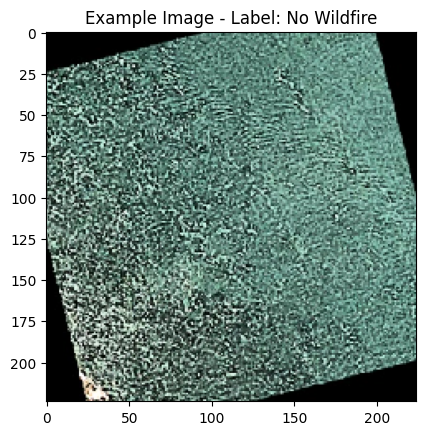

In [43]:
example_batch = next(train_generator)

# Extract the first image and label from the batch
example_image = example_batch[0][0]
example_label = example_batch[1][0]

if example_label == 1.0:
    label = "Wildfire"
else:
    label = "No Wildfire"
input_shape=example_image.shape
# Display the example image and label
plt.imshow(example_image)
plt.title(f"Example Image - Label: {label}")
plt.show()

In [63]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.utils import plot_model

class OwnEfficientNetB0:
    @staticmethod
    def build(input_shape, trainable=False, dropout=0.2):
        inputs = keras.Input(shape=input_shape)
        baseModel = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=inputs)
        baseModel.trainable = trainable
        headModel = baseModel.output
        headModel = layers.GlobalAveragePooling2D()(headModel)
        headModel = layers.Dropout(dropout)(headModel)
        outputs = layers.Dense(1, activation="sigmoid")(headModel)
        model = Model(inputs, outputs)
        return model

In [54]:
def model_train():
    learning_rate = 1e-5
    image_size = (img_width, img_height)
    model = OwnEfficientNetB0.build(input_shape=image_size + (3,))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, mode='min', min_delta=0.0001)]
    
    #keep batchlayers intact, reduces learning time
    for layer in model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=keras.metrics.BinaryAccuracy())
    callbacks = [
    EarlyStopping(monitor='val_loss', patience = 5, mode = 'min', min_delta = 0.0001)
    ModelCheckpoint('best_model.h5',monitor = 'val_loss',save_best_only = True)
    ]
    history = model.fit(train_generator, epochs=15,validation_data=valid_generator)
    return history


In [55]:
history = model_train()

Epoch 1/15
47/47 [==============================] - 278s 6s/step - loss: 0.6861 - binary_accuracy: 0.5583 - val_loss: 0.6485 - val_binary_accuracy: 0.7083
Epoch 2/15
47/47 [==============================] - 273s 6s/step - loss: 0.6134 - binary_accuracy: 0.6787 - val_loss: 0.5225 - val_binary_accuracy: 0.7650
Epoch 3/15
47/47 [==============================] - 272s 6s/step - loss: 0.5617 - binary_accuracy: 0.7160 - val_loss: 0.5346 - val_binary_accuracy: 0.7367
Epoch 4/15
47/47 [==============================] - 280s 6s/step - loss: 0.5375 - binary_accuracy: 0.7423 - val_loss: 0.4802 - val_binary_accuracy: 0.7817
Epoch 5/15
47/47 [==============================] - 382s 8s/step - loss: 0.5309 - binary_accuracy: 0.7463 - val_loss: 0.4710 - val_binary_accuracy: 0.7750
Epoch 6/15
47/47 [==============================] - 385s 8s/step - loss: 0.5254 - binary_accuracy: 0.7490 - val_loss: 0.5289 - val_binary_accuracy: 0.7367
Epoch 7/15
47/47 [==============================] - 369s 8s/step - los

KeyError: 'accuracy'

In [69]:
print(history.history)
image_size = (img_width, img_height)
model = OwnEfficientNetB0.build(input_shape=image_size + (3,))
preds = model.predict(test_generator)  
test_loss, test_acc = model.evaluate(test_generator) 

{'loss': [0.686122715473175, 0.6133823394775391, 0.5617250800132751, 0.5374536514282227, 0.5309084057807922, 0.5254030227661133, 0.5143024325370789, 0.5118112564086914, 0.5012780427932739, 0.5090054869651794, 0.5113943219184875, 0.4994077980518341, 0.5064356327056885, 0.4848634898662567, 0.48458513617515564], 'binary_accuracy': [0.5583333373069763, 0.6786666512489319, 0.7160000205039978, 0.7423333525657654, 0.7463333606719971, 0.7490000128746033, 0.7583333253860474, 0.7609999775886536, 0.7673333287239075, 0.762333333492279, 0.7606666684150696, 0.7703333497047424, 0.762333333492279, 0.7730000019073486, 0.7789999842643738], 'val_loss': [0.648495614528656, 0.5224524736404419, 0.5346004366874695, 0.4801863133907318, 0.4709753394126892, 0.5289226174354553, 0.4510626792907715, 0.45160460472106934, 0.4766913950443268, 0.4777587950229645, 0.44134095311164856, 0.5746785998344421, 0.4364921450614929, 0.43168386816978455, 0.42288199067115784], 'val_binary_accuracy': [0.7083333134651184, 0.7649999

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [66]:
import numpy as np

preds = model.predict(test_generator)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(test_generator) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

NameError: name 'model' is not defined